#Why Regression Fails for Forecasting: A Retail Sales Example

##Step 1: Setting Up Your Python Environment


In [ ]:
# Import necessary libraries for data manipulation, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Set plotting style for better visualizations
sns.set_theme(style='whitegrid')
sns.set_palette("deep")

##Step 2: Loading and Exploring the Shampoo Sales Dataset


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19669  100 19669    0     0  25812      0 --:--:-- --:--:-- --:--:-- 25812
Archive:  time-series-datasets.zip
  inflating: Electric_Production.csv  
  inflating: daily-minimum-temperatures-in-me.csv  
  inflating: monthly-beer-production-in-austr.csv  
  inflating: sales-of-shampoo-over-a-three-ye.csv  
Raw data preview:
   Month  Sales of shampoo over a three year period
0  1-Jan                                      266.0
1  1-Feb                                      145.9
2  1-Mar                                      183.1
3  1-Apr                                      119.3
4  1-May                                      180.3

Cleaned data:
   Month  Sales
0  1-Jan  266.0
1  1-Feb  145.9
2  1-Mar  183.1
3  1-Apr  119.3
4  1-May  180.3

Dataset info

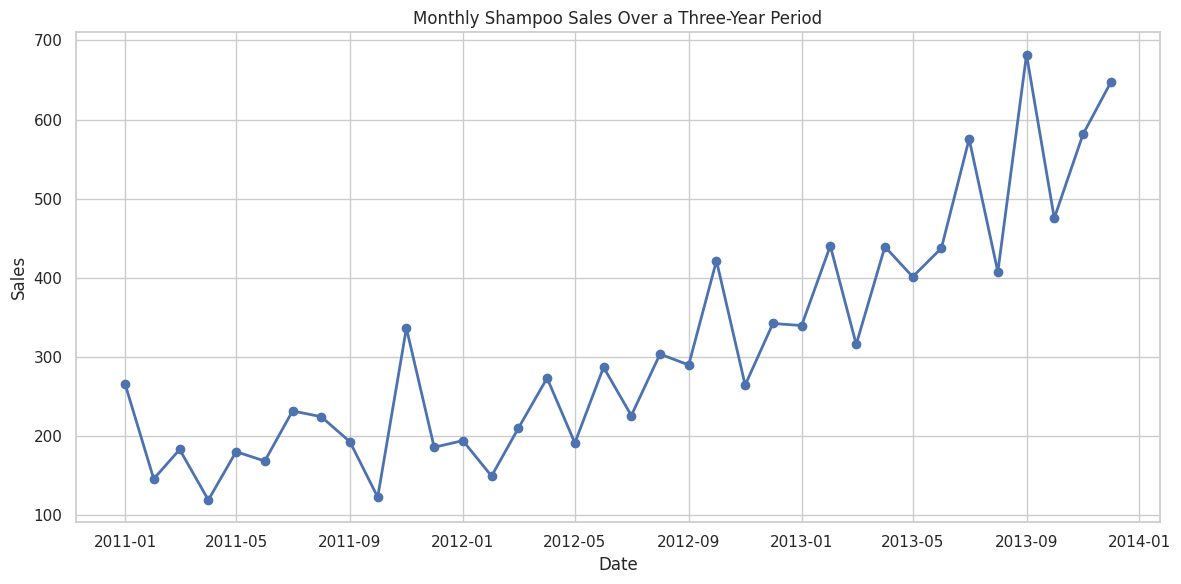

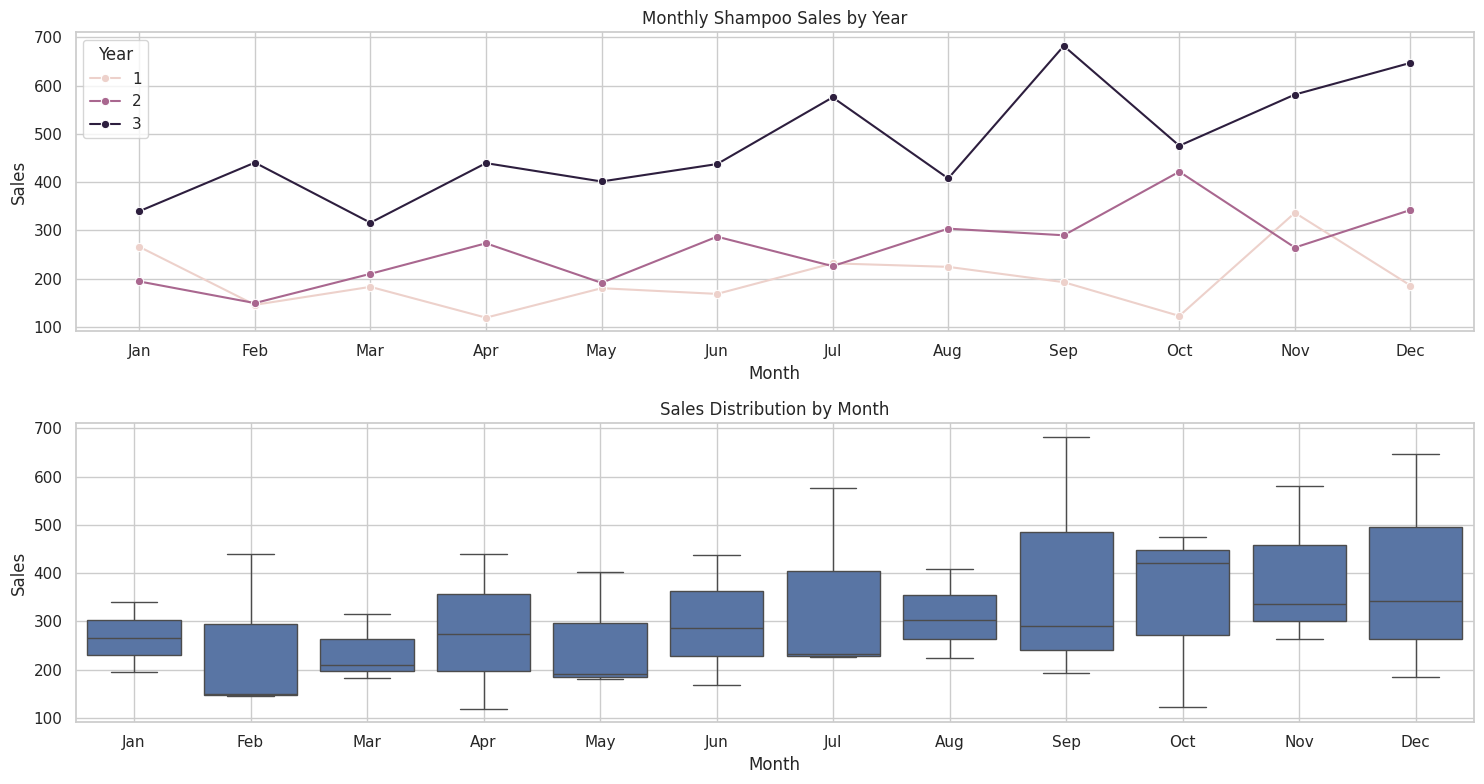

In [ ]:
# Load the retail sales dataset
# The parse_dates parameter converts the 'Date' column to datetime
# Setting index_col='Date' makes the date the index of our DataFrame

!curl -L -o ./time-series-datasets.zip\
  https://www.kaggle.com/api/v1/datasets/download/shenba/time-series-datasets
!unzip -o time-series-datasets.zip
# Load the shampoo sales dataset
# The data structure needs parsing as it seems to be in an unusual format
data = pd.read_csv('sales-of-shampoo-over-a-three-ye.csv')

# Extract the data from the mixed format
# First, let's examine the raw data to understand its structure
print("Raw data preview:")
print(data.head())

data = data.rename(columns={'Sales of shampoo over a three year period': 'Sales'})

print("\nCleaned data:")
print(data.head())

# Convert Month to datetime for proper time series analysis
# Format is like "1-Jan", "1-Feb", etc., indicating year-month
data['Year'] = data['Month'].str.split('-').str[0].astype(int)
data['Month_Name'] = data['Month'].str.split('-').str[1]

# Create a proper date column
month_dict = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
data['Month_Num'] = data['Month_Name'].map(month_dict)
data['Date'] = pd.to_datetime(data.apply(
    lambda x: f'201{x["Year"]}-{x["Month_Num"]:02d}-01', axis=1
))

# Sort by date and set it as index
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# Basic statistics and info
print("\nDataset information:")
print(data.info())
print("\nStatistical summary:")
print(data['Sales'].describe())

# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Sales'], marker='o', linestyle='-', linewidth=2)
plt.title('Monthly Shampoo Sales Over a Three-Year Period')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

# Check for seasonality and trend
plt.figure(figsize=(15, 8))

# Plot sales by month across years
plt.subplot(2, 1, 1)
sns.lineplot(x='Month_Num', y='Sales', hue='Year', data=data, marker='o')
plt.title('Monthly Shampoo Sales by Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Box plot by month to see seasonal patterns
plt.subplot(2, 1, 2)
sns.boxplot(x='Month_Num', y='Sales', data=data)
plt.title('Sales Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

plt.tight_layout()
plt.show()

##Step 3: Applying Linear Regression to Analyze Time Series

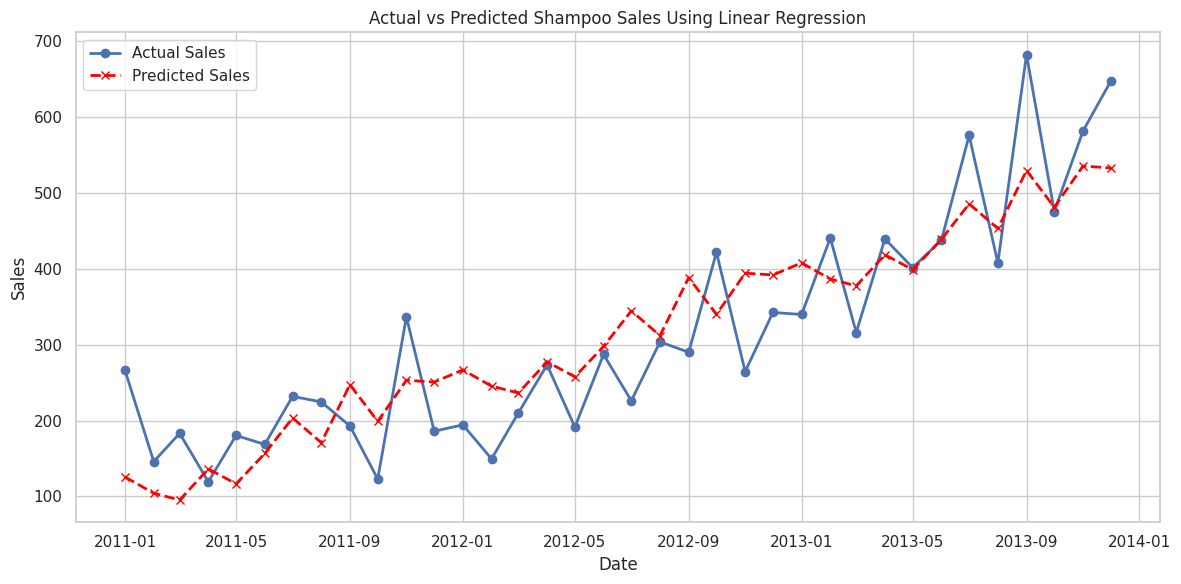

Mean Squared Error: 5193.21
Root Mean Squared Error: 72.06

Model Coefficients:
     Feature  Coefficient
0      Trend    11.753819
1    Month_1    18.712674
2    Month_2   -14.441146
3    Month_3   -35.094965
4    Month_4    -5.915451
5    Month_5   -37.302604
6    Month_6    -9.089757
7    Month_7    25.956424
8    Month_8   -18.330729
9    Month_9    46.248785
10  Month_10   -13.805035
11  Month_11    28.607812
12  Month_12    14.453993
Intercept: 106.91


In [ ]:
# Prepare data for linear regression
# We'll use basic time-based features
data['Month_Index'] = range(len(data))  # Simple numeric index
data['Trend'] = data['Month_Index']     # Linear trend feature

# Add seasonal features (month of year)
for month in range(1, 13):
    data[f'Month_{month}'] = (data['Month_Num'] == month).astype(int)

# Define features (X) and target variable (y) for our regression model
X = data[['Trend', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
          'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']]
y = data['Sales']

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions using the trained model
data['Predicted'] = model.predict(X)

# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Sales'], marker='o', linestyle='-',
         label='Actual Sales', linewidth=2)
plt.plot(data.index, data['Predicted'], marker='x', linestyle='--',
         label='Predicted Sales', color='red', linewidth=2)
plt.title('Actual vs Predicted Shampoo Sales Using Linear Regression')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate model performance
mse = mean_squared_error(data['Sales'], data['Predicted'])
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

# Examine model coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print("\nModel Coefficients:")
print(coef_df)
print(f"Intercept: {model.intercept_:.2f}")

##Step 4: Highlighting the Shortcomings of Traditional Approaches


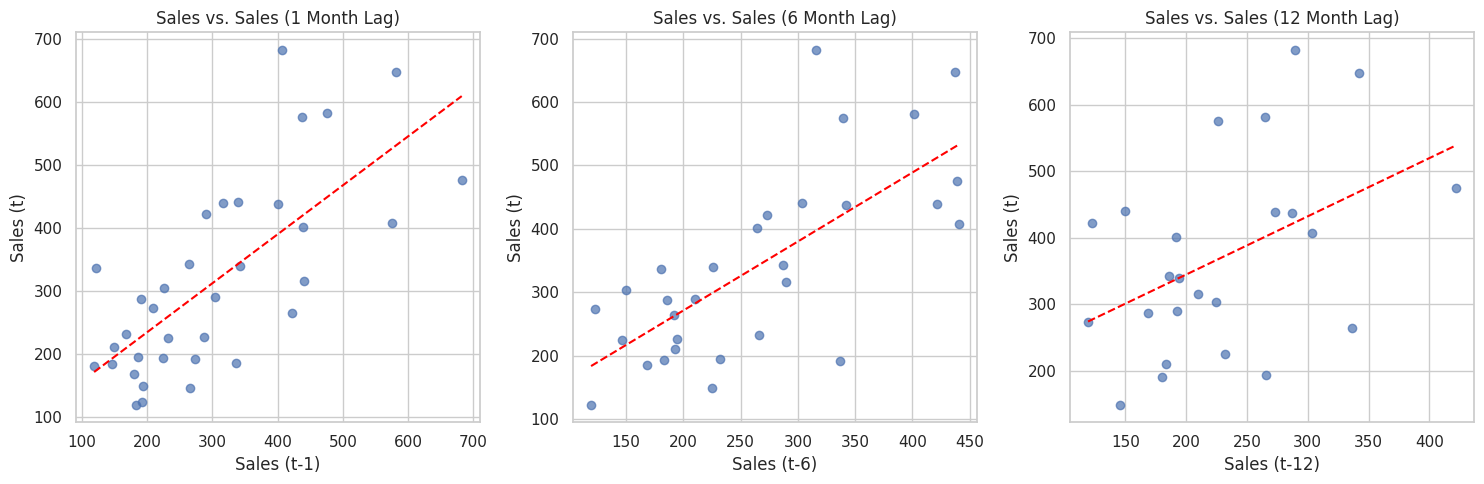

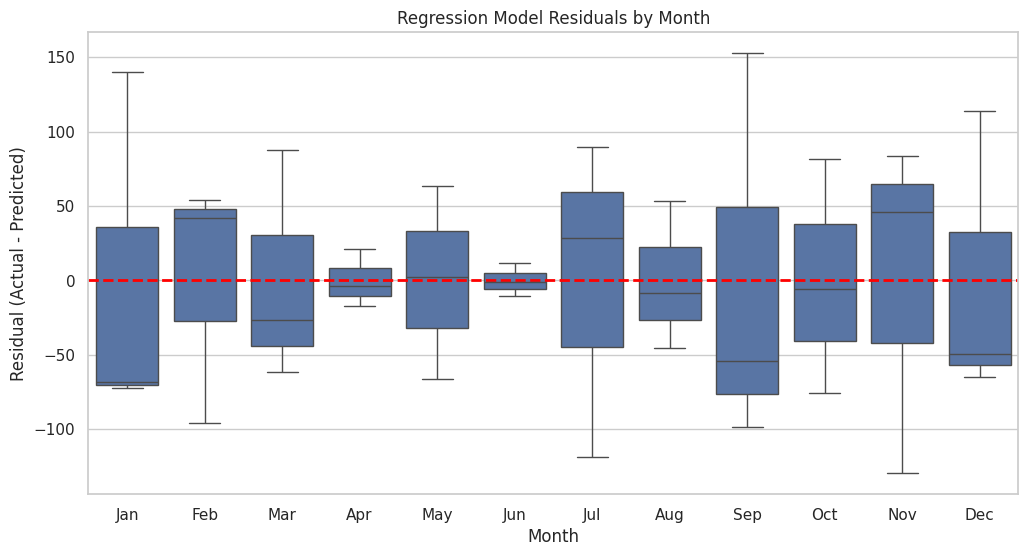

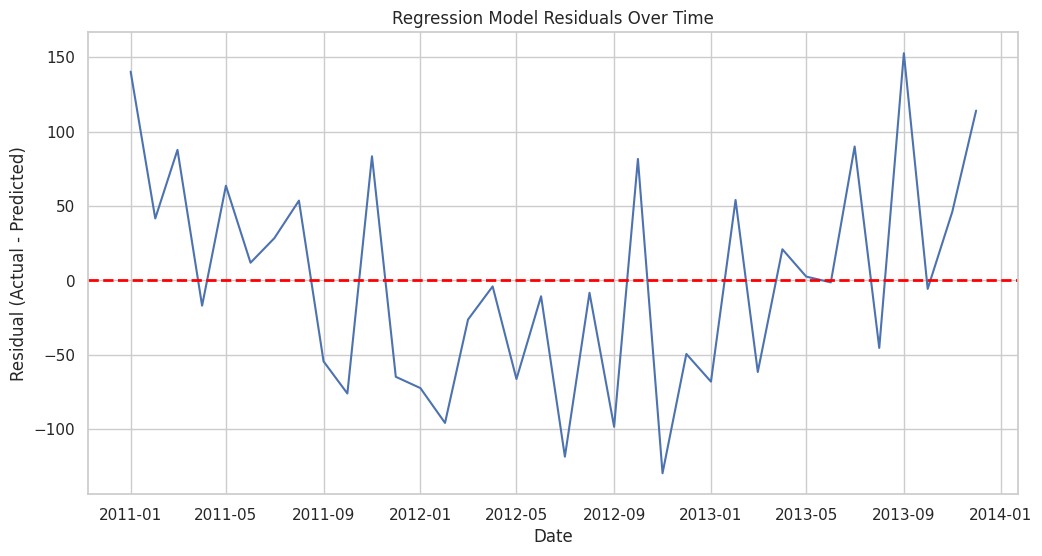

Key Limitations of Linear Regression for Time Series Analysis:
1. Ignores Autocorrelation: The strong relationship between sales and its lagged values
   is not properly accounted for in the linear regression model.
2. Misses Complex Seasonality: Even with month dummy variables, the model doesn't
   fully capture the changing seasonal patterns over time.
3. Static Assumptions: The regression assumes relationships remain constant, but
   the patterns in shampoo sales evolve over the three-year period.
4. No Handling of Trend-Season Interactions: The model treats trend and seasonality
   as independent factors, ignoring how they might influence each other.


In [ ]:
# added during screencast
# 1. Visualizing the problem of ignoring autocorrelation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(data['Sales'].shift(1), data['Sales'], alpha=0.7)
plt.plot(np.unique(data['Sales'].shift(1)), np.poly1d(np.polyfit(
    data['Sales'].shift(1).dropna(), data['Sales'].iloc[1:], 1))(np.unique(data['Sales'].shift(1))),
    color='red', linestyle='--')
plt.title('Sales vs. Sales (1 Month Lag)')
plt.xlabel('Sales (t-1)')
plt.ylabel('Sales (t)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(data['Sales'].shift(6).iloc[6:], data['Sales'].iloc[6:], alpha=0.7) # Changed here
plt.plot(np.unique(data['Sales'].shift(6).dropna()), np.poly1d(np.polyfit(
    data['Sales'].shift(6).dropna(), data['Sales'].iloc[6:], 1))(np.unique(data['Sales'].shift(6).dropna())),
    color='red', linestyle='--')
plt.title('Sales vs. Sales (6 Month Lag)')
plt.xlabel('Sales (t-6)')
plt.ylabel('Sales (t)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(data['Sales'].shift(12).iloc[12:], data['Sales'].iloc[12:], alpha=0.7) # Changed here
plt.plot(np.unique(data['Sales'].shift(12).dropna()), np.poly1d(np.polyfit(
    data['Sales'].shift(12).dropna(), data['Sales'].iloc[12:], 1))(np.unique(data['Sales'].shift(12).dropna())),
    color='red', linestyle='--')
plt.title('Sales vs. Sales (12 Month Lag)')
plt.xlabel('Sales (t-12)')
plt.ylabel('Sales (t)')
plt.grid(True)

plt.tight_layout()
plt.show()

# added during screencast
# 2. Demonstrating missed seasonality despite having month features
# Plot model residuals by month to show seasonality not fully captured
data['Residuals'] = data['Sales'] - data['Predicted']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Month_Num', y='Residuals', data=data)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Regression Model Residuals by Month')
plt.xlabel('Month')
plt.ylabel('Residual (Actual - Predicted)')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, axis='y')
plt.show()

# added during screencast
# 3. Illustrating static assumptions problem
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Residuals'])
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Regression Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.show()

# Print key limitations in a clear format
print("Key Limitations of Linear Regression for Time Series Analysis:")
print("1. Ignores Autocorrelation: The strong relationship between sales and its lagged values")
print("   is not properly accounted for in the linear regression model.")
print("2. Misses Complex Seasonality: Even with month dummy variables, the model doesn't")
print("   fully capture the changing seasonal patterns over time.")
print("3. Static Assumptions: The regression assumes relationships remain constant, but")
print("   the patterns in shampoo sales evolve over the three-year period.")
print("4. No Handling of Trend-Season Interactions: The model treats trend and seasonality")
print("   as independent factors, ignoring how they might influence each other.")

#What Makes Forecasting Different: Let's Try ARIMA & Exponential Smoothing

##Step 1: Implementing ARIMA for Forecasting


Checking stationarity of original shampoo sales data:
Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64
Data is non-stationary (fail to reject H0)

Checking stationarity after differencing:
Results of Dickey-Fuller Test:
Test Statistic                -7.249074e+00
p-value                        1.799857e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64
Data is stationary (reject H0)

Training data size: 30
Test data size: 6

Fitting ARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   30
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -154.649
Date:                Thu, 15 May 2025   AIC                            323.298
Time:                        19:17:20   BIC                            332.624
Sample:                    01-01-2011   HQIC                           326.149
                         - 06-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0595      0.864     -0.069      0.945      -1.753       1.634
ar.L2          0.2024      0.810      0.250      0.803      -1.385       1.790
ar.L3         -0.0255      0.647     -0.039      0.9

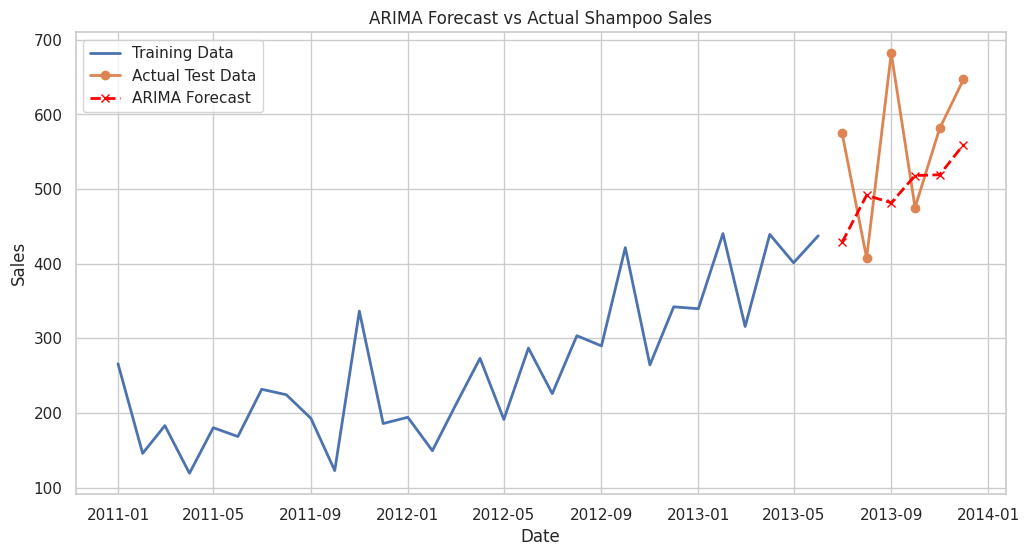

ARIMA Mean Squared Error: 13691.48
ARIMA Root Mean Squared Error: 117.01


In [ ]:
# added during screencast
# Prepare data for time series modeling
ts_data = data['Sales']

# Check stationarity (required for ARIMA)
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Interpret the results
    if dftest[1] <= 0.05:
        print("Data is stationary (reject H0)")
    else:
        print("Data is non-stationary (fail to reject H0)")

# Check stationarity of the original series
print("Checking stationarity of original shampoo sales data:")
check_stationarity(ts_data)

# If needed, difference the data to make it stationary
ts_data_diff = ts_data.diff().dropna()

# Check stationarity of differenced series
print("\nChecking stationarity after differencing:")
check_stationarity(ts_data_diff)

# Split data into train and test sets (last 6 months for testing)
train_size = len(ts_data) - 6
train = ts_data[:train_size]
test = ts_data[train_size:]

print(f"\nTraining data size: {len(train)}")
print(f"Test data size: {len(test)}")

# Fit ARIMA model
# Choose order based on ACF, PACF plots or AIC/BIC criteria
# For this example, we'll use ARIMA(4,2,2)
print("\nFitting ARIMA model...")
model = ARIMA(train, order=(4, 2, 2))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecast against actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', linewidth=2)
plt.plot(test.index, test, label='Actual Test Data', marker='o', linewidth=2)
plt.plot(test.index, forecast, color='red', label='ARIMA Forecast',
         marker='x', linestyle='--', linewidth=2)
plt.title('ARIMA Forecast vs Actual Shampoo Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Calculate forecast accuracy
arima_mse = mean_squared_error(test, forecast)
print(f"ARIMA Mean Squared Error: {arima_mse:.2f}")
print(f"ARIMA Root Mean Squared Error: {np.sqrt(arima_mse):.2f}")

##Step 2: Exploring Exponential Smoothing


Fitting Exponential Smoothing model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


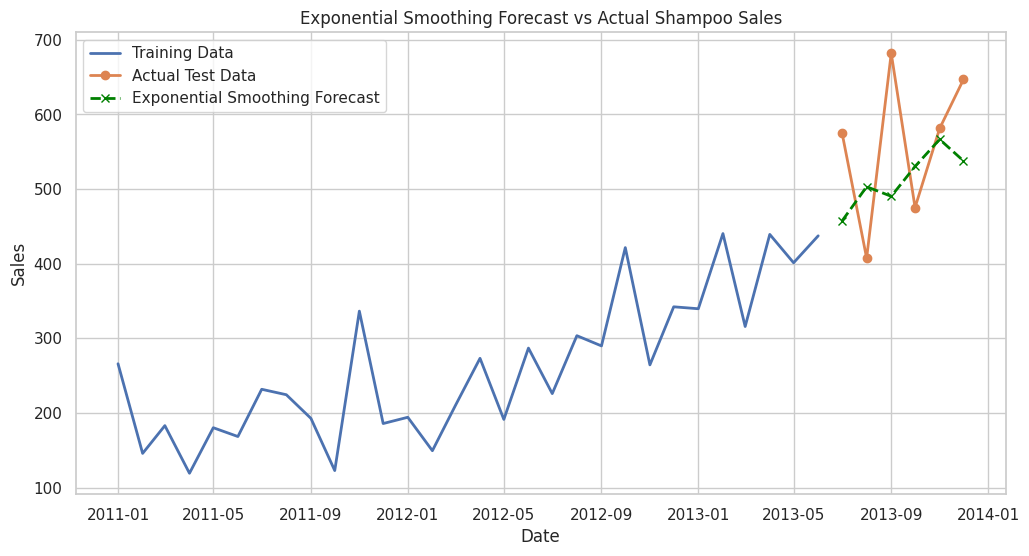

Exponential Smoothing Mean Squared Error: 12498.76
Exponential Smoothing Root Mean Squared Error: 111.80


In [ ]:
# added during screencast
# Apply Exponential Smoothing to our shampoo sales data
print("Fitting Exponential Smoothing model...")
# We'll use Holt-Winters' method to capture both trend and seasonality
model_exp_smoothing = ExponentialSmoothing(
    train,
    trend='add',           # Add trend component
    seasonal='add',        # Add seasonal component
    seasonal_periods=12    # Monthly data, so seasonality period is 12
)
model_fit_exp = model_exp_smoothing.fit()

# Generate forecasts
forecast_exp = model_fit_exp.forecast(steps=forecast_steps)

# Plot the Exponential Smoothing forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', linewidth=2)
plt.plot(test.index, test, label='Actual Test Data', marker='o', linewidth=2)
plt.plot(test.index, forecast_exp, color='green', label='Exponential Smoothing Forecast',
         marker='x', linestyle='--', linewidth=2)
plt.title('Exponential Smoothing Forecast vs Actual Shampoo Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Calculate forecast accuracy
exp_smoothing_mse = mean_squared_error(test, forecast_exp)
print(f"Exponential Smoothing Mean Squared Error: {exp_smoothing_mse:.2f}")
print(f"Exponential Smoothing Root Mean Squared Error: {np.sqrt(exp_smoothing_mse):.2f}")